In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

from scipy.stats import f_oneway
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import kstest, norm
import scipy.stats as stats
from scipy.stats import spearmanr
from sklearn.preprocessing import PowerTransformer
from scipy.stats import kruskal
from scipy.stats import chi2_contingency
import matplotlib as mpl


# 차원 축소
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 군집
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

# 학습 모델 저장을 위한 라이브러리
import pickle

### 가설 7 :  연체 잔액이 높은 고객은 주로 A, B 등급의 핵심 고객군에 집중될 것이다.
 - 총잔액, 연체잔액

In [2]:
# ✅ 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
# 데이터 불러오기
df_member = pd.read_parquet("open/train/1.회원정보/201807_train_회원정보.parquet")
df_balance = pd.read_parquet("open/train/5.잔액정보/201807_train_잔액정보.parquet")

In [4]:
# 분석할 잔액 컬럼 선택
balance_cols = [
    '잔액_일시불_B0M',
    '잔액_할부_B0M',
    '잔액_현금서비스_B0M',
    '잔액_카드론_B0M',
    '월중평잔_일시불_B0M',
    '월중평잔_할부_B0M',
    'RV_평균잔액_R6M',
]

In [7]:
# 필요한 컬럼만 추출
cols = [
    'ID', 
    '정상청구원금_B0M', 
    '이용금액_할부_B0M', 
    '이용금액_일시불_B0M'
]
df_approval = df_approval[cols]

In [8]:
# 병합
df = pd.merge(df_approval, df_member[['ID', 'Segment']], on='ID', how='inner')

In [5]:
# 필요한 컬럼만 추출
df_balance = df_balance[['ID'] + balance_cols + ['연체잔액_B0M']]

# 결측치는 0으로 대체
df_balance[balance_cols + ['연체잔액_B0M']] = df_balance[balance_cols + ['연체잔액_B0M']].fillna(0)

# 회원정보와 병합
df = pd.merge(df_balance, df_member[['ID', 'Segment']], on='ID', how='inner')

In [6]:
# Segment 문자형 및 순서 지정
df['Segment'] = df['Segment'].astype(str)
df['Segment'] = pd.Categorical(df['Segment'], categories=['A', 'B', 'C', 'D', 'E'], ordered=True)

In [8]:
# 총잔액 컬럼 생성 (잔액 합산)
df['총잔액'] = df[balance_cols].sum(axis=1)
df

,ID,잔액_일시불_B0M,잔액_할부_B0M,잔액_현금서비스_B0M,잔액_카드론_B0M,월중평잔_일시불_B0M,월중평잔_할부_B0M,RV_평균잔액_R6M,연체잔액_B0M,Segment,총잔액
0,TRAIN_000000,998,962,22971,0,1084,547,0,0,D,26562
1,TRAIN_000001,2565,2390,0,0,4090,2553,0,0,E,11598
2,TRAIN_000002,5312,5113,21531,0,5006,8778,1847,0,C,47587
3,TRAIN_000003,730,5025,26284,0,487,5607,0,0,D,38133
4,TRAIN_000004,0,0,0,0,0,0,0,0,E,0
...,...,...,...,...,...,...,...,...,...,...,...
399995,TRAIN_399995,0,0,0,0,0,0,0,0,E,0
399996,TRAIN_399996,6374,0,0,29839,10598,0,0,0,D,46811
399997,TRAIN_399997,2168,0,0,0,1831,0,0,0,C,3999
399998,TRAIN_399998,0,0,0,0,0,0,0,0,E,0


### 총잔액

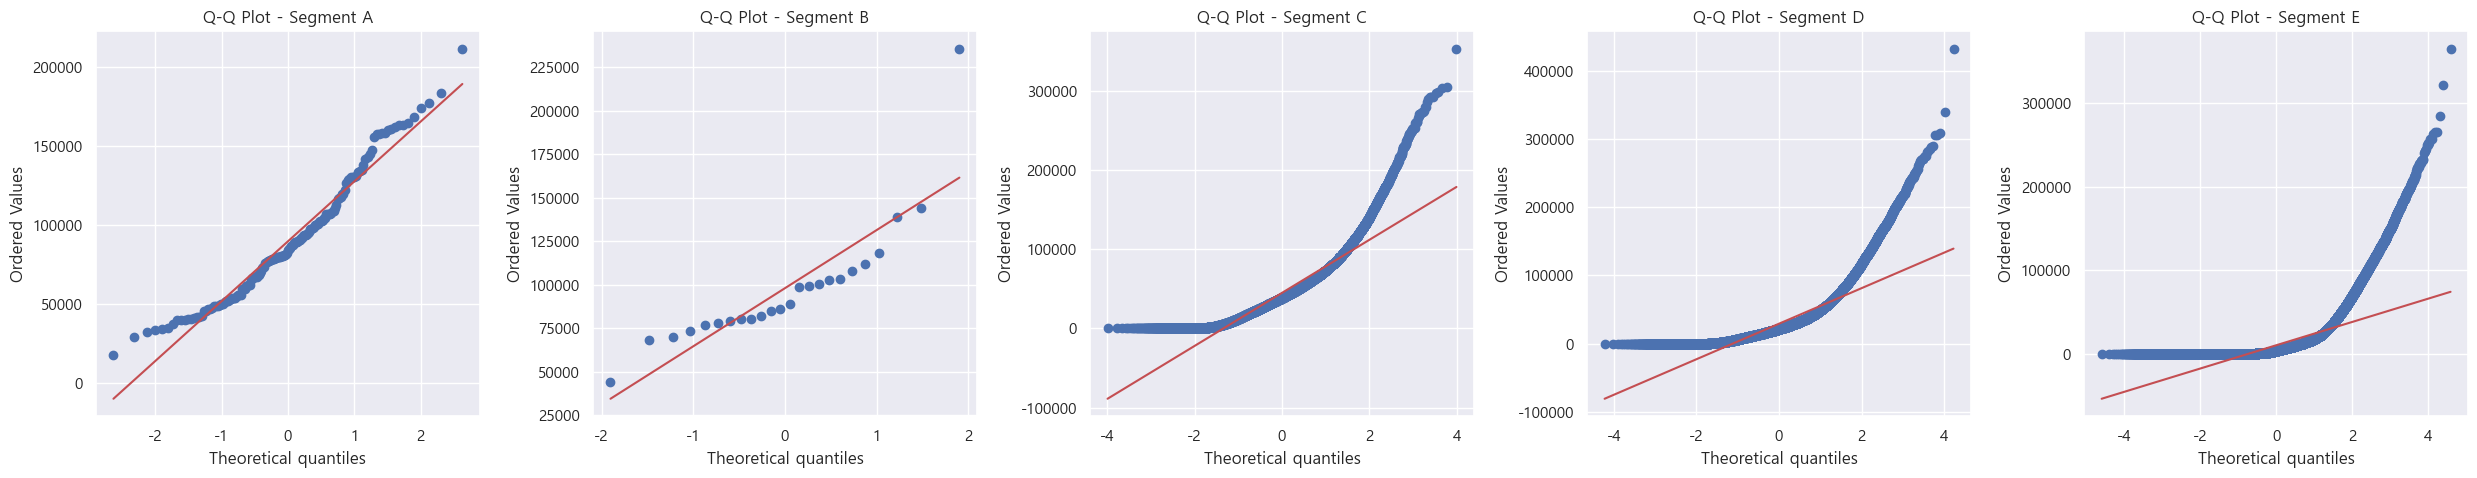

In [19]:
# Segment별 Q-Q Plot
segments = df['Segment'].unique()
num_segments = len(segments)

plt.figure(figsize=(5 * num_segments, 5))

for i, seg in enumerate(sorted(segments)):
    plt.subplot(1, num_segments, i + 1)
    stats.probplot(
        df[df['Segment'] == seg]['총잔액'], 
        dist="norm", 
        plot=plt
    )
    plt.title(f"Q-Q Plot - Segment {seg}")

plt.tight_layout()
plt.show()

In [12]:
# Segment별로 금액을 리스트로 분리
grouped_data = [
    df[df['Segment'] == seg]['총잔액'].dropna()
    for seg in sorted(df['Segment'].unique())
]

In [13]:
# Kruskal-Wallis H-test 수행
stat, p = kruskal(*grouped_data)

# 결과값 출력
print(f"Kruskal-Wallis H-statistic: {stat:.4f}")
print(f"p-value: {p:.4f}")

if p < 0.05:
    print("→ 유의미한 차이가 있음. 귀무가설 기각됨")
else:
    print("→ 유의미한 차이가 없음. 귀무가설 채택.")

Kruskal-Wallis H-statistic: 76048.1284
p-value: 0.0000
→ 유의미한 차이가 있음. 귀무가설 기각됨


In [14]:
import scikit_posthocs as sp

# 사후검정 실시
sp.posthoc_dunn(df, val_col='총잔액', group_col='Segment', p_adjust='bonferroni')

,A,B,C,D,E
A,1.000000e+00,1.000000e+00,5.222162e-10,2.984821e-25,1.326296e-118
B,1.000000e+00,1.000000e+00,5.600054e-02,1.558290e-04,4.016131e-19
C,5.222162e-10,5.600054e-02,1.000000e+00,0.000000e+00,0.000000e+00
D,2.984821e-25,1.558290e-04,0.000000e+00,1.000000e+00,0.000000e+00
E,1.326296e-118,4.016131e-19,0.000000e+00,0.000000e+00,1.000000e+00


- Segment A와 B간의 유의확률은 0.05보다 크게 나타났다.
- 즉, 이들 간에는 Segment별 차이가 통계적으로 유의하지 않다.

### 연체잔액_B0M

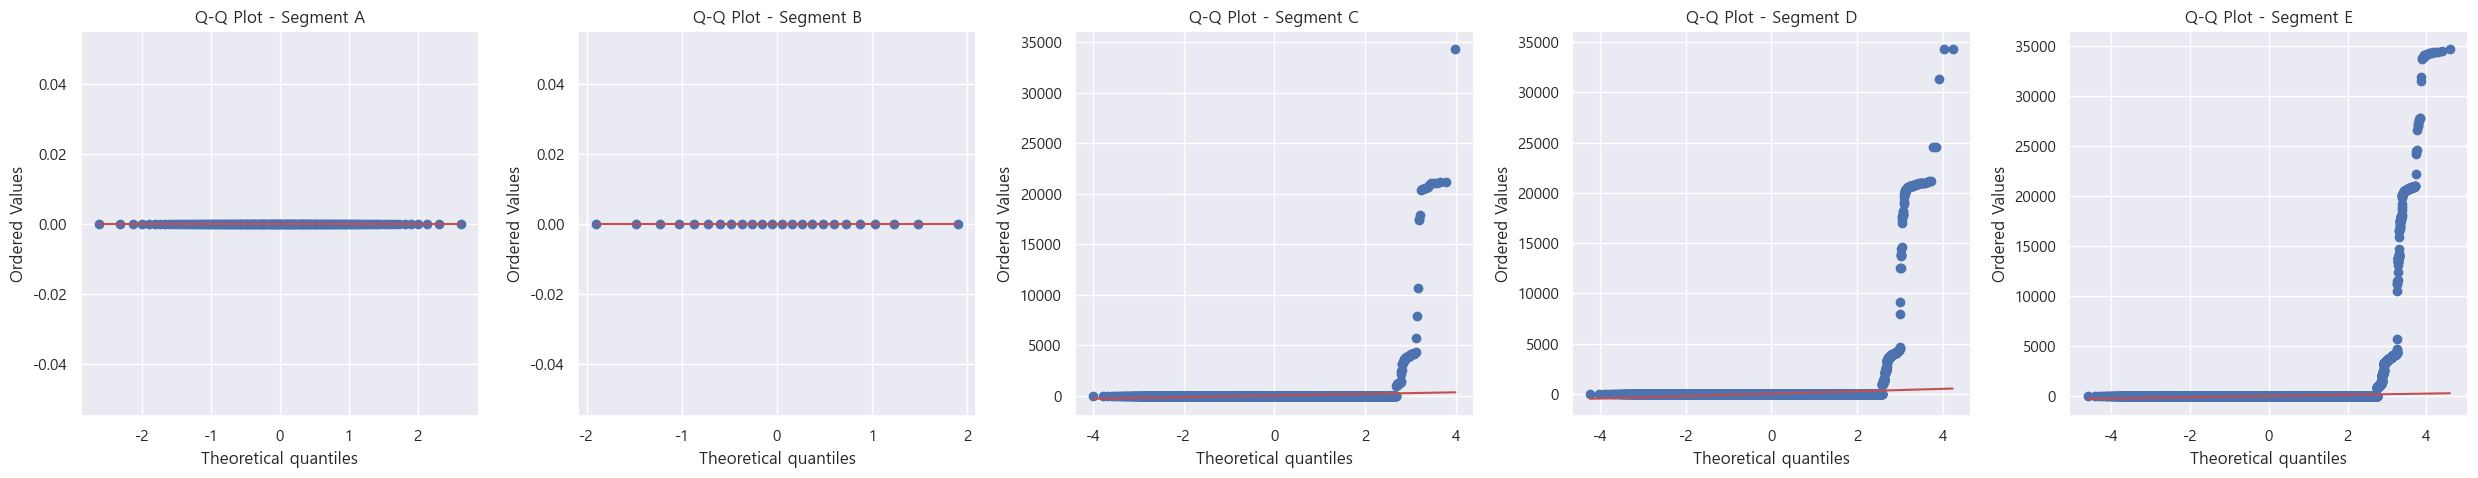

In [18]:
# Segment별 Q-Q Plot
segments = df['Segment'].unique()
num_segments = len(segments)

plt.figure(figsize=(5 * num_segments, 5))

for i, seg in enumerate(sorted(segments)):
    plt.subplot(1, num_segments, i + 1)
    stats.probplot(
        df[df['Segment'] == seg]['연체잔액_B0M'], 
        dist="norm", 
        plot=plt
    )
    plt.title(f"Q-Q Plot - Segment {seg}")

plt.tight_layout()
plt.show()

- Segment A, B
- 거의 모든 점이 0에 집중되어 있고, 수평선 위에 존재
- 분산이 거의 없고, 데이터가 편향되거나 단일값(혹은 매우 좁은 값 범위)
- 즉, 정규성 판단 자체가 무의미함.

- Segment C, D, E
- Q-Q Plot에서 우측 상단에서 직선에서 크게 벗어나는 것으로 보아 양의 왜도가 존재함.

-즉, 모든 그룹에서 정규성을 위배한다.

In [15]:
# Segment별로 금액을 리스트로 분리
grouped_data = [
    df[df['Segment'] == seg]['연체잔액_B0M'].dropna()
    for seg in sorted(df['Segment'].unique())
]

In [16]:
# Kruskal-Wallis H-test 수행
stat, p = kruskal(*grouped_data)

# 결과값 출력
print(f"Kruskal-Wallis H-statistic: {stat:.4f}")
print(f"p-value: {p:.4f}")

if p < 0.05:
    print("→ 유의미한 차이가 있음. 귀무가설 기각됨")
else:
    print("→ 유의미한 차이가 없음. 귀무가설 채택.")

Kruskal-Wallis H-statistic: 57.4109
p-value: 0.0000
→ 유의미한 차이가 있음. 귀무가설 기각됨


In [17]:
import scikit_posthocs as sp

# 사후검정 실시
sp.posthoc_dunn(df, val_col='연체잔액_B0M', group_col='Segment', p_adjust='bonferroni')

,A,B,C,D,E
A,1.0,1.0,1.00000,1.000000e+00,1.000000e+00
B,1.0,1.0,1.00000,1.000000e+00,1.000000e+00
C,1.0,1.0,1.00000,3.472041e-02,1.000000e+00
D,1.0,1.0,0.03472,1.000000e+00,6.362873e-13
E,1.0,1.0,1.00000,6.362873e-13,1.000000e+00


- Segment C와 D, D와 E를 제외한 나머지 그룹들 간에 당월 연체잔액 차이는 유의미하지 않다.